## Introduction

**Identifying members** is the foundational step when studying an open cluster, as it significantly affects the estimation of its physical parameters. Various techniques have been employed for this purpose, including analyses based on proper motions, radial velocities, photometric data, and their combinations.

In this effort, I plan to implement the following methods:
- **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**
- **GMM (Gaussian Mixture Model)**
- **KMeans**
- and potentially others.

I start by performing the HDBSCAN clustering.

## Data Preparation

- Import library
- Loading the dataset
- Data validation
- Data cleaning
- Feature addition


### Import library

In [30]:
# Import library
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import math
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import hdbscan
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.model_selection import GridSearchCV
from utils.utils import ClusterViz

### Loading the dataset

I am using a cone search directed at the center of the M45 star cluster with a radius of 3 degrees. The data used is sourced from Gaia DR3.

In [2]:
# ## Uncomment this block of script if you've done it once 
# ## so you don't have to download it multiple times
# Gaia.ROW_LIMIT = -1 # Set to -1 for no row limit
# ra, dec = 56.85, 24.1167 # RA, Dec of M45
# coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
# j = Gaia.cone_search_async(coord, radius=u.Quantity(3.0, u.deg)) # Cone search with 3 degrees radius
# gaia_result = j.get_results()
# raw_df = gaia_result.to_pandas() # Covert to pandas dataframe
# raw_df.to_csv('gaiaedr3_M45.csv', index=False)

In [3]:
# Load the data
FILENAME = "./gaiaedr3_M45.csv"
raw_df = pd.read_csv(FILENAME, delimiter=",")
# Select columns
columns = ["pmra", "pmdec", "parallax", "ra", "dec", 
           "phot_g_mean_flux_error", "phot_g_mean_flux",
           "phot_bp_mean_flux_error", "phot_bp_mean_flux",
           "phot_rp_mean_flux_error", "phot_rp_mean_flux",
           "phot_g_mean_mag", "phot_bp_mean_mag", 
           "phot_rp_mean_mag"]
raw_df = raw_df[columns]

### Data Validation

In [4]:
# Checking the data
print("Data shape:", raw_df.shape)
print("Data summary:")
raw_df.describe().T

Data shape: (257231, 14)
Data summary:


,count,mean,std,min,25%,50%,75%,max
pmra,222794.0,2.869325,9.002622e+00,-293.338097,-0.275285,1.275331,4.163522,8.724843e+02
pmdec,222794.0,-4.585140,9.363686e+00,-1157.434442,-5.877124,-2.357292,-0.731895,1.969323e+02
parallax,222794.0,0.776594,1.354555e+00,-17.562348,0.178540,0.538342,1.115612,7.498865e+01
ra,257231.0,57.065388,1.632845e+00,53.564199,55.777809,57.162409,58.390606,6.013532e+01
dec,257231.0,24.272511,1.495057e+00,21.116861,23.090854,24.331559,25.485114,2.711657e+01
phot_g_mean_flux_error,256839.0,59.419778,1.043421e+04,0.565921,0.940130,1.197986,1.849912,4.226650e+06
phot_g_mean_flux,256839.0,40915.025673,3.609524e+06,23.241533,135.627003,353.201289,1481.922653,1.307657e+09
phot_bp_mean_flux_error,252953.0,142.399084,4.245321e+04,0.000013,7.440292,9.383103,12.431332,2.092370e+07
phot_bp_mean_flux,252953.0,25745.099325,2.525265e+06,1.221373,60.469705,131.429209,611.449817,8.410149e+08
phot_rp_mean_flux_error,253878.0,73.742053,1.269126e+04,0.001949,8.510300,10.379328,13.372285,6.209676e+06


In [5]:
print("Missing values:")
raw_df.isna().sum().apply(lambda x: f"{x/raw_df.shape[0]:.2%}")[list(map(lambda x: x > 0, raw_df.isna().sum()))]

Missing values:


pmra                       13.39%
pmdec                      13.39%
parallax                   13.39%
phot_g_mean_flux_error      0.15%
phot_g_mean_flux            0.15%
phot_bp_mean_flux_error     1.66%
phot_bp_mean_flux           1.66%
phot_rp_mean_flux_error     1.30%
phot_rp_mean_flux           1.30%
phot_g_mean_mag             0.15%
phot_bp_mean_mag            1.66%
phot_rp_mean_mag            1.30%
dtype: object

In [6]:
print("Duplicated values: ", raw_df[raw_df.duplicated()].shape[0])

Duplicated values:  0


### Data Cleaning

I proceed the stars that satisfy the following criteria (Agarwal et al. 2021):
- Each source must have the five astrometric parameters, positions, proper motions, and parallax as well as valid measurements in the three photometric passbands G, GBP, and GRP in the Gaia DR3 catalogue.
- Their parallax values must be non-negative.
- To eliminate sources with high uncertainty while still retaining a fraction of sources down to G ∼ 21 mag, the errors in their G-mag must be less than 0.005.

In [ ]:
# Removing NaN values in raw_df
modified_df = raw_df.dropna().reset_index()

# Validate the data
print("Data shape:", raw_df.shape)
print("Missing values:")
modified_df.isna().sum().apply(lambda x: f"{x/modified_df.shape[0]:.2%}")[list(map(lambda x: x > 0, modified_df.isna().sum()))]


Data shape: (257231, 14)
Missing values:


Series([], dtype: object)

In [8]:
# Removing negative-values parallax
modified_df = modified_df[modified_df['parallax'] > 0]

# Validate the data
print("Data shape:", raw_df.shape)

Data shape: (257231, 14)


To eliminate sources with high uncertainty while still retaining a fraction of sources down to G ∼ 21 mag, we need to calculate the error of $\text{G}$ ($|\sigma_G|$) and select the measurement with the errors less than 0.005.

```math
|\sigma_G| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_G}}{F_G} 
```

In [9]:
# Calculate the errors
modified_df['e_Gmag'] = abs(-2.5*modified_df['phot_g_mean_flux_error']/math.log(10)/modified_df['phot_g_mean_flux'])

# Filter the error
modified_df = modified_df[modified_df['e_Gmag'] < 0.005].reset_index(drop=True)

# Validate the data
print("Data shape:", raw_df.shape)

Data shape: (257231, 14)


### Feature Addition

In [10]:
# Add BP - RP color index
modified_df['bp_rp'] = modified_df['phot_bp_mean_mag'] - modified_df['phot_rp_mean_mag']

In [11]:
# Adjust the RA and Dec of the stars
coor_all  = SkyCoord(ra=modified_df.ra, dec=modified_df.dec, frame='icrs', unit=(u.deg, u.deg))

modified_df['ra']  = coor_all.ra.wrap_at(180 * u.deg).degree
modified_df['dec']  = coor_all.dec.degree

## Building HDBSCAN Model

In [12]:
# Feature selection
X = modified_df[["pmra", "pmdec", "parallax"]]


In [13]:
# Data Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
# Building HDBSCAN model
clusterer = hdbscan.HDBSCAN() # Create a model with default hyperparameter
cluster_labels = clusterer.fit_predict(X)

modified_df['label'] = cluster_labels

Model Evaluation

In [15]:
# View the clustering result
modified_df['label'].value_counts()

-1       104327
 7         1078
 2959        73
 2348        71
 3814        63
          ...  
 495          5
 1922         5
 1410         5
 3435         5
 520          5
Name: label, Length: 3883, dtype: int64

In [16]:
# Remove the noise from evaluation
evaluated_df = modified_df[modified_df['label'] != -1]

# Evaluate silhouette score
score = silhouette_score(evaluated_df, evaluated_df['label']) 
print(f'Silhouette Score: {score}')

# Evaluate Davies-Bouldin Index score
db_score = davies_bouldin_score(evaluated_df, evaluated_df['label']) 
print(f'Davies-Bouldin Score: {db_score}')

Silhouette Score: -0.7612576267146131
Davies-Bouldin Score: 184.33163436958793


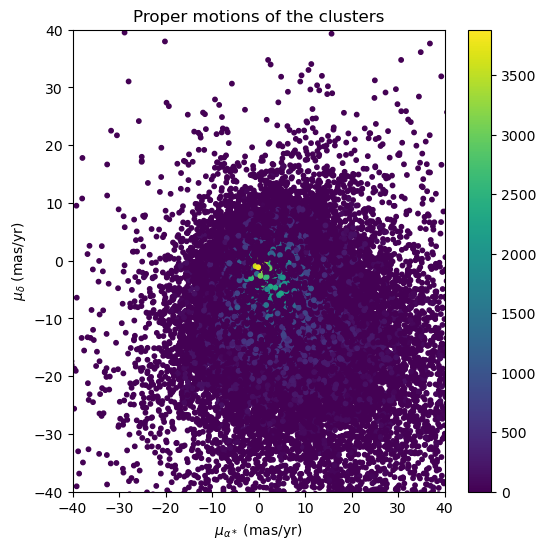

In [17]:
# Proper motion plot
ClusterViz.show_pmra_pmdec_plot(modified_df, (-40, 40), (-40, 40))

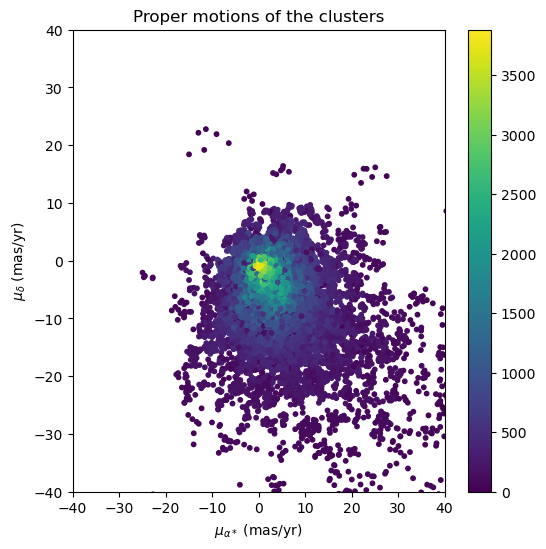

In [18]:
# Proper motion plot without the noise
ClusterViz.show_pmra_pmdec_plot(modified_df[modified_df.label != -1], (-40, 40), (-40, 40))

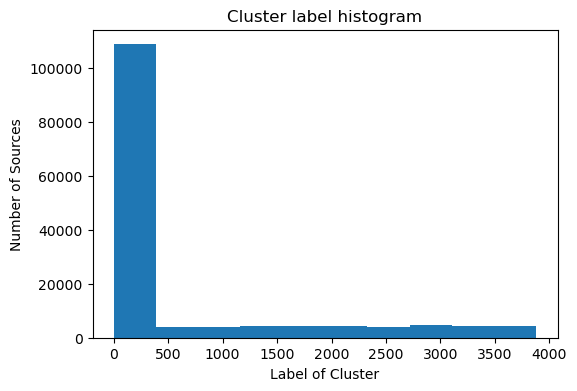

In [19]:
# Show label histrogram
ClusterViz.show_label_hist(modified_df)

In [20]:
# Show label counts
modified_df['label'].value_counts().sort_values(ascending=False)

-1       104327
 7         1078
 2959        73
 2348        71
 3814        63
          ...  
 1557         5
 1070         5
 1241         5
 3116         5
 520          5
Name: label, Length: 3883, dtype: int64

In [21]:
# Select only valid and largest label counts data
clustered_df = modified_df[modified_df.label != -1].reset_index(drop=True)

c = clustered_df['label'].value_counts()

n_max = c.index[np.argmax(c)]

clustered_df = clustered_df[clustered_df.label == n_max]

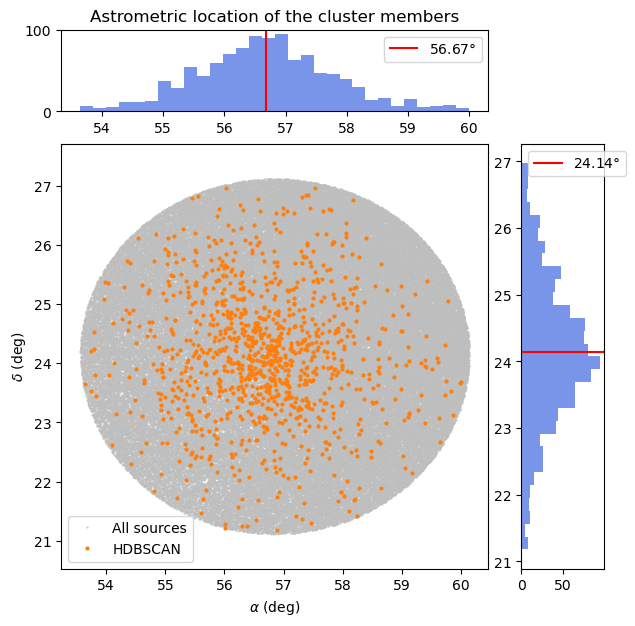

In [22]:
# Show position of the clusters
ClusterViz.show_locations(modified_df, clustered_df)


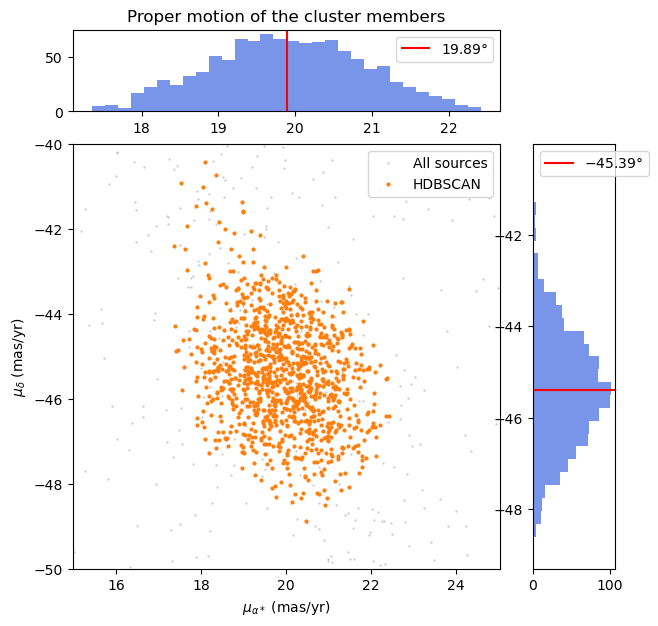

In [23]:
# Show the proper motion of the cluster
ClusterViz.show_proper_motions(modified_df, clustered_df, xlim=(15,25), ylim=(-50, -40))

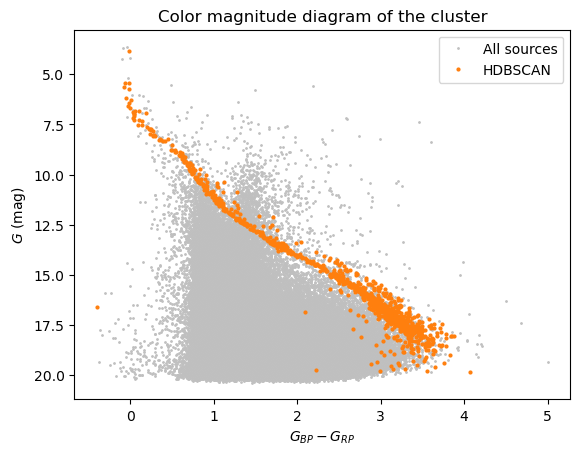

In [24]:
# Show the Color-Magnitude Diagram (CMD)
ClusterViz.show_cmd(modified_df, clustered_df)

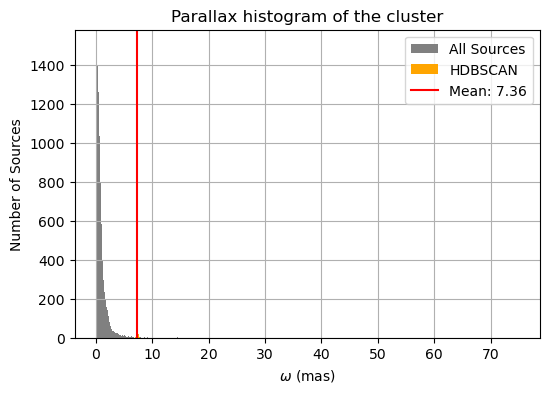

In [25]:
# Show parallax histogram
ClusterViz.show_parallax_hist(modified_df, clustered_df)

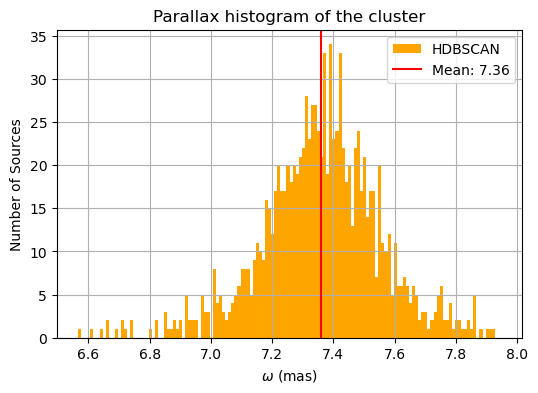

In [26]:
# Show parallax histogram (clustered only)
ClusterViz.show_parallax_hist(modified_df, clustered_df, show_all=False)

In [27]:
# Summarize the info in a dictionary
cluster_info = {}
cluster_info['HDBSCAN'] = ClusterViz.get_cluster_info(clustered_df)

Cluster info:

ra_c			=  56.672
dec_c			=  24.140
pmra_c			=  19.892
pmdec_c			=  -45.390
parallax_c			=  7.360
dist_c			=  0.136


Hyperparameter Tuning

In [32]:
param_grid = {
    'min_cluster_size': [5, 10, 20, 100],
    'alpha': [1.0, 1.5, 2.0]
}

In [33]:
clusterer = hdbscan.HDBSCAN()
grid_search = GridSearchCV(clusterer, param_grid, scoring=silhouette_score, cv=5, n_jobs=-1)
grid_search.fit(X)  

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

c:\Users\mohfi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best hyperparameters: {'alpha': 1.0, 'min_cluster_size': 5}


In [34]:
# Building HDBSCAN model
clusterer = hdbscan.HDBSCAN(500) # Create a model with arbitrary hyperparameter
cluster_labels = clusterer.fit_predict(X)

modified_df['label'] = cluster_labels

# Remove the noise from evaluation
evaluated_df = modified_df[modified_df['label'] != -1]

# Evaluate silhouette score
score = silhouette_score(evaluated_df, evaluated_df['label']) 
print(f'Silhouette Score: {score}')

# Evaluate Davies-Bouldin Index score
db_score = davies_bouldin_score(evaluated_df, evaluated_df['label']) 
print(f'Davies-Bouldin Score: {db_score}')

Silhouette Score: 0.9545380503439873
Davies-Bouldin Score: 1.8217291942993028


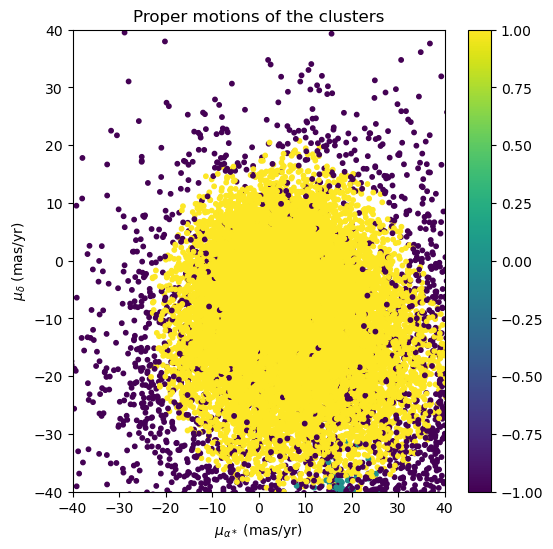

In [35]:
# Proper motion plot
ClusterViz.show_pmra_pmdec_plot(modified_df, (-40, 40), (-40, 40))

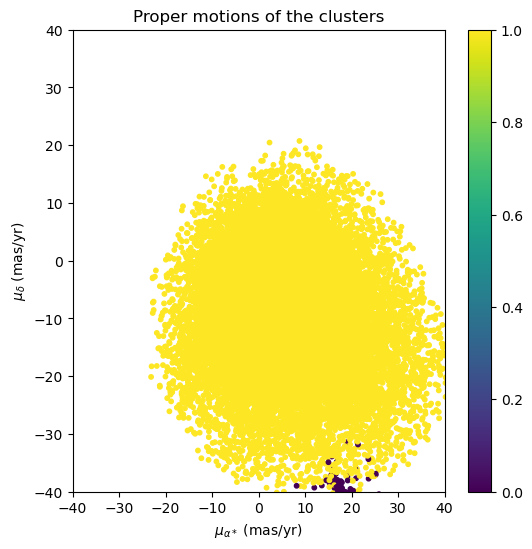

In [36]:
# Proper motion plot without the noise
ClusterViz.show_pmra_pmdec_plot(modified_df[modified_df.label != -1], (-40, 40), (-40, 40))

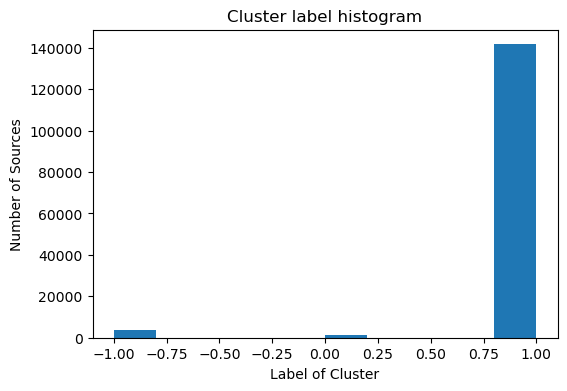

In [37]:
# Show label histrogram
ClusterViz.show_label_hist(modified_df)

In [38]:
# Show label counts
modified_df['label'].value_counts().sort_values(ascending=False)

 1    141565
-1      3795
 0      1368
Name: label, dtype: int64

In [39]:
# Select only valid and largest label counts data
clustered_df = modified_df[modified_df.label != -1].reset_index(drop=True)

c = clustered_df['label'].value_counts()

n_max = c.index[np.argmax(c)]

clustered_df = clustered_df[clustered_df.label == n_max]

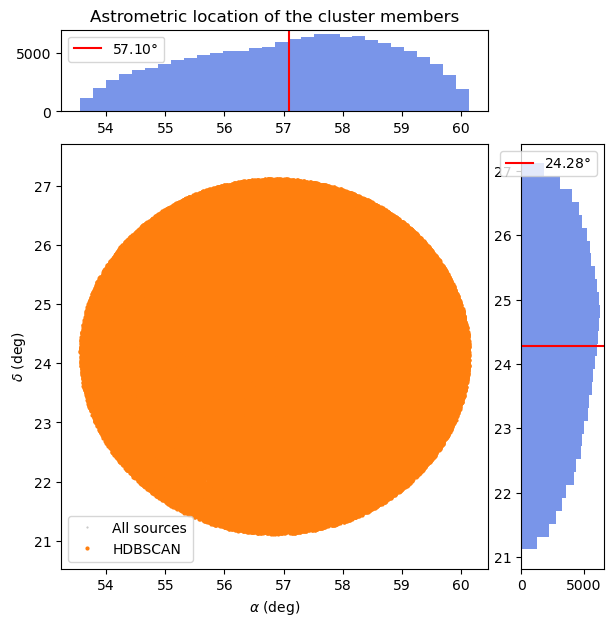

In [40]:
# Show position of the clusters
ClusterViz.show_locations(modified_df, clustered_df)


In [43]:
clustered_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,141565.0,129195.578038,73928.104988,3.000000,65402.000000,129261.000000,193134.000000,2.572300e+05
pmra,141565.0,2.517535,5.528293,-23.130977,-0.215812,1.367690,4.232627,4.129280e+01
pmdec,141565.0,-4.099429,5.571014,-40.418413,-6.057779,-2.593598,-0.820524,2.073809e+01
parallax,141565.0,0.797309,0.707007,0.000065,0.312053,0.592121,1.052921,5.240763e+00
ra,141565.0,57.098147,1.632395,53.564199,55.811540,57.222175,58.417606,6.013526e+01
dec,141565.0,24.277243,1.497537,21.117898,23.089599,24.336516,25.493988,2.711516e+01
phot_g_mean_flux_error,141565.0,8.678924,339.297547,0.605916,1.050015,1.444193,2.461139,8.830274e+04
phot_g_mean_flux,141565.0,19316.540207,409004.912891,134.029047,406.152001,1016.499102,3581.398005,9.353500e+07
phot_bp_mean_flux_error,141565.0,19.660865,439.402366,0.002472,7.939745,9.952888,13.013126,1.300775e+05
phot_bp_mean_flux,141565.0,8637.268201,203411.648946,24.943563,134.911625,396.007289,1575.144640,5.237634e+07


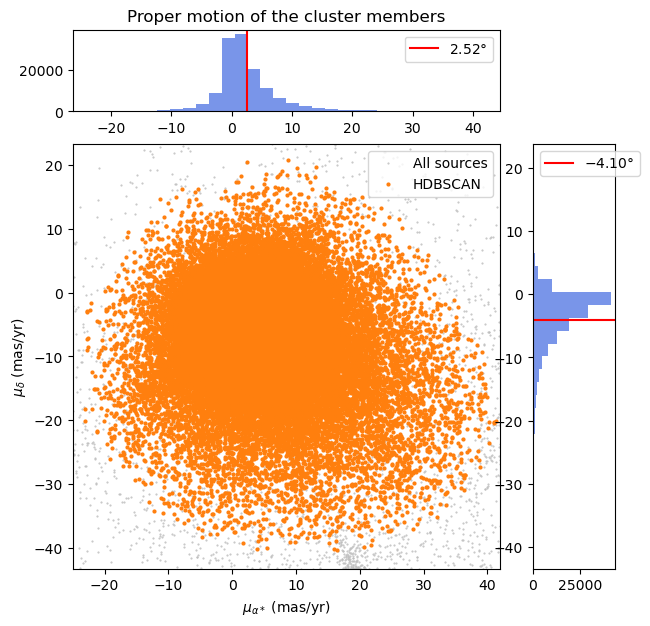

In [44]:
# Show the proper motion of the cluster
ClusterViz.show_proper_motions(modified_df, clustered_df, xlim=(-25,42), ylim=(-41, 21))

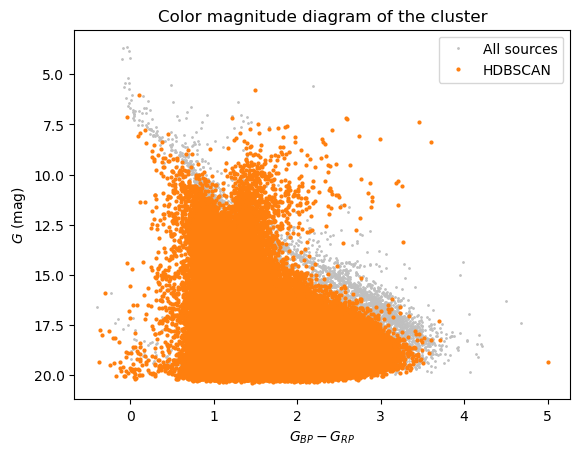

In [45]:
# Show the Color-Magnitude Diagram (CMD)
ClusterViz.show_cmd(modified_df, clustered_df)

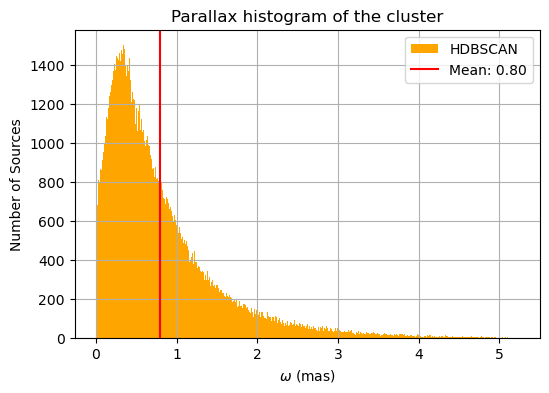

In [46]:
# Show parallax histogram (clustered only)
ClusterViz.show_parallax_hist(modified_df, clustered_df, show_all=False)

In [47]:
# Summarize the info in a dictionary
cluster_info = {}
ClusterViz.get_cluster_info(clustered_df)

Cluster info:

ra_c			=  57.098
dec_c			=  24.277
pmra_c			=  2.518
pmdec_c			=  -4.099
parallax_c			=  0.797
dist_c			=  1.254


{'ra_c': 57.098147425446,
 'dec_c': 24.277242546605148,
 'pmra_c': 2.5175349649616336,
 'pmdec_c': -4.099428615559163,
 'parallax_c': 0.7973090968245132,
 'dist_c': 1.2542187264421727}